In [2]:
from order_routerv2 import *
import tensorflow as tf
from keras.models import load_model
from utils import*
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor
from datetime import*
import pickle as pkl


from alpaca.data.historical import *
from alpaca.data.requests import *
from alpaca.data.timeframe import *
from alpaca.data.enums import *
from alpaca.trading.client import *
from alpaca.trading.requests import * 
from alpaca.trading.enums import *

with open('multi_scaler3.pkl','rb') as f:
    multi_scaler=pkl.load(f)
with open('encoder.pkl','rb') as f:
    encoder=pkl.load(f)
    

In [3]:
trader=Trader(model=load_model('model3.keras'),multi_scaler=multi_scaler,encoder=encoder)


In [5]:
def get_bars(symbol_or_symbols,time):
        start_time=time - timedelta(days=20)
        request_params = StockBarsRequest(
            symbol_or_symbols=symbol_or_symbols,
            timeframe=TimeFrame(1, TimeFrameUnit('Min')),
            start=start_time,
            end=time,
            adjustment=Adjustment.ALL,
            feed='sip'
        )
    
        return trader.client.get_stock_bars(request_params).df
    

<Axes: xlabel='symbol,timestamp'>

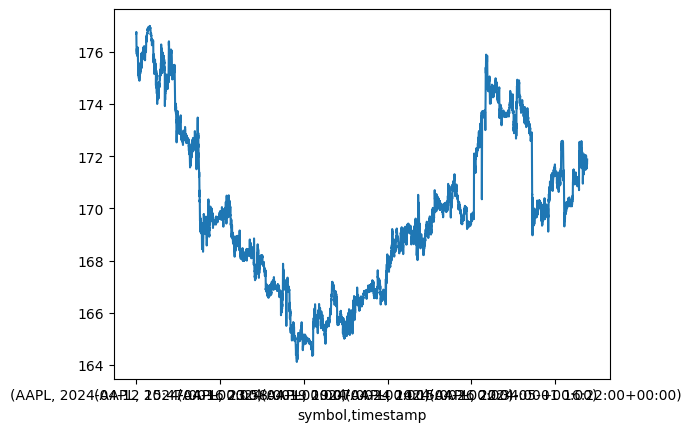

In [6]:
get_bars('AAPL',datetime.now())['close'].plot()

In [37]:
data=get_bars('AAPL',datetime.now()).loc['AAPL']
data

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2024-04-12 15:52:00+00:00,176.4900,176.490,176.320,176.3350,169364.0,1478.0,176.388884
2024-04-12 15:53:00+00:00,176.3350,176.335,176.135,176.2100,191711.0,1684.0,176.217032
2024-04-12 15:54:00+00:00,176.2050,176.250,176.140,176.1950,160920.0,1251.0,176.182111
2024-04-12 15:55:00+00:00,176.1950,176.200,176.115,176.1200,118604.0,1118.0,176.148258
2024-04-12 15:56:00+00:00,176.1226,176.150,175.940,175.9550,156500.0,1691.0,176.057454
...,...,...,...,...,...,...,...
2024-05-02 15:46:00+00:00,171.8650,171.920,171.740,171.7400,90386.0,1183.0,171.839566
2024-05-02 15:47:00+00:00,171.7400,171.810,171.730,171.7778,72707.0,801.0,171.761003
2024-05-02 15:48:00+00:00,171.7700,171.780,171.665,171.7000,70569.0,883.0,171.720307


In [80]:
df=data.copy()
df['close_cma']=df['close'].rolling(1000,center=True).mean()
df['close_cma_osc']=df['close_cma'].diff().rolling(100,center=True).mean()
df['oscillator']=(df['close']-df['close_cma'])#.rolling(100,center=True).mean()

(<Axes: >,)

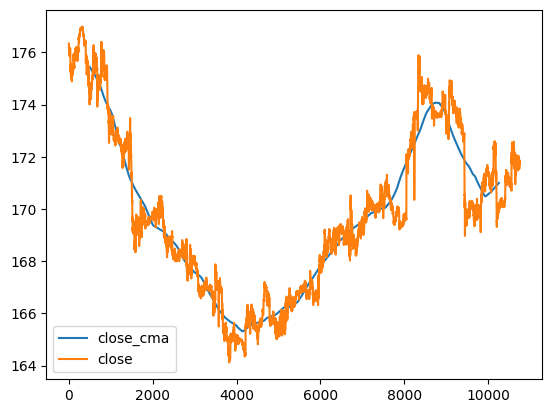

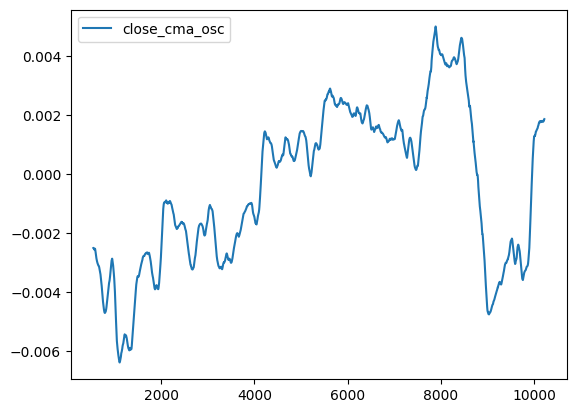

In [81]:
df[['close_cma','close']].reset_index(drop=True).plot(subplots=False),
df[['close_cma_osc']].reset_index(drop=True).plot(subplots=False),


In [5]:
df=data.copy()
df_resampled = df['open'].resample('1h').first()

# Create a DataFrame to hold the start prices and another to track the events
start_prices = df_resampled.dropna()
events = pd.DataFrame(index=start_prices.index, columns=['Event Occurred'])

# For each interval, track if the price falls below 0.1% of the start price and rises back
for interval_start in start_prices.index:
    interval_data = df.loc[interval_start:interval_start + pd.Timedelta(minutes=14)]
    start_price = start_prices[interval_start]
    threshold = start_price * 0.9975 
    event_occurred = False
    
    # Tracking the event in each minute within the interval
    below_threshold = interval_data['low'] < threshold
    if below_threshold.any():
        # Find when it first goes below threshold
        first_below = below_threshold.idxmax()
        # Check if it rises above start price after dropping below threshold
        subsequent_data = interval_data.loc[first_below:]
        if (subsequent_data['high'] > start_price).any():
            event_occurred = True
    
    events.loc[interval_start, 'Event Occurred'] = event_occurred

# Calculate the probability
probability = events['Event Occurred'].mean()
probability

NameError: name 'data' is not defined

In [7]:

df=pd.DataFrame(pos,columns=Position.model_fields).apply(lambda x : x.apply(lambda x : x[1])).set_index('symbol')


In [88]:
positions=trader.trading_client.get_all_positions()

positions[0]

{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
    'asset_id': UUID('b0b6dd9d-8b9b-48a9-ba46-b9d54906e415'),
    'asset_marginable': True,
    'avg_entry_price': '172.15',
    'avg_entry_swap_rate': None,
    'change_today': '0.0170998227997637',
    'cost_basis': '-2410.1',
    'current_price': '172.195',
    'exchange': <AssetExchange.NASDAQ: 'NASDAQ'>,
    'lastday_price': '169.3',
    'market_value': '-2410.73',
    'qty': '-14',
    'qty_available': '-14',
    'side': <PositionSide.SHORT: 'short'>,
    'swap_rate': None,
    'symbol': 'AAPL',
    'unrealized_intraday_pl': '-0.63',
    'unrealized_intraday_plpc': '-0.0002613999419111',
    'unrealized_pl': '-0.63',
    'unrealized_plpc': '-0.0002613999419111',
    'usd': None}

In [97]:
for position in positions:
    entry=abs(float(position.avg_entry_price))
    cost_base=abs(float(position.current_price))
    print(f"{position.symbol} : {(cost_base/entry*100)-100:.2f}%, {float(position.unrealized_plpc)*100:.2f}%")

AAPL : 0.03%, -0.03%
ABNB : -0.07%, 0.07%
ADI : 0.03%, -0.03%
AMAT : -0.02%, 0.02%
AMD : -0.08%, 0.08%
AMZN : 0.02%, 0.02%
BAC : -0.07%, -0.07%
BLK : -0.03%, 0.03%
BMY : 0.05%, 0.05%
BRK.B : -0.06%, -0.06%
BX : -0.08%, 0.08%
C : 0.02%, -0.02%
CAT : -0.08%, 0.08%
CI : 0.09%, 0.09%
CMCSA : 0.00%, 0.00%
COP : 0.05%, 0.05%
CSCO : -0.02%, -0.02%
CVX : -0.01%, 0.01%
DIS : 0.01%, 0.01%
ELV : 0.09%, -0.09%
FI : -0.15%, 0.15%
GE : 0.06%, -0.06%
HD : -0.08%, -0.08%
HON : 0.02%, -0.02%
JNJ : 0.08%, 0.08%
KO : 0.03%, -0.03%
LLY : 0.13%, 0.13%
LMT : -0.01%, 0.01%
LOW : -0.03%, -0.03%
LRCX : -0.08%, 0.08%
MCD : 0.01%, -0.01%
MDLZ : 0.04%, 0.04%
MRK : 0.01%, 0.01%
MS : 0.08%, 0.08%
NEE : 0.01%, 0.01%
NKE : 0.03%, -0.03%
NOW : -0.10%, -0.10%
PANW : -0.07%, 0.07%
PEP : -0.01%, -0.01%
PFE : 0.20%, 0.20%
PLD : 0.01%, -0.01%
PM : -0.04%, 0.04%
RTX : 0.00%, 0.00%
SCHW : 0.09%, 0.09%
T : -0.03%, -0.03%
TJX : 0.02%, 0.02%
TMUS : -0.00%, -0.00%
UNH : 0.02%, 0.02%
UNP : -0.02%, 0.02%
UPS : 0.09%, 0.09%
V : 0.0

In [114]:
trader.trading_client.get_orders(GetOrdersRequest(
    status='closed',
))

[{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
     'asset_id': UUID('5ddc1e60-daca-45da-b2de-f3ee597e60bc'),
     'canceled_at': None,
     'client_order_id': '08532857-d510-46ae-ad71-c8b579eb945c',
     'created_at': datetime.datetime(2024, 5, 2, 16, 14, 31, 148557, tzinfo=TzInfo(UTC)),
     'expired_at': None,
     'extended_hours': False,
     'failed_at': None,
     'filled_at': datetime.datetime(2024, 5, 2, 16, 14, 32, 302684, tzinfo=TzInfo(UTC)),
     'filled_avg_price': '38.19',
     'filled_qty': '91',
     'hwm': None,
     'id': UUID('7c7bed75-a435-4ad5-a353-33eef14a4035'),
     'legs': None,
     'limit_price': None,
     'notional': None,
     'order_class': <OrderClass.SIMPLE: 'simple'>,
     'order_type': <OrderType.MARKET: 'market'>,
     'qty': '91',
     'replaced_at': None,
     'replaced_by': None,
     'replaces': None,
     'side': <OrderSide.SELL: 'sell'>,
     'status': <OrderStatus.FILLED: 'filled'>,
     'stop_price': None,
     'submitted_at': datet